# 2019-nCoV outbreak analysis

## Background
A novel coronavirus (2019-nCoV) outbreak has been continuing in China, while a few imported cases are observed in the neighbouring countries. Although the spread across China suggests a certain amount of human-to-human transmisison, there has not been any observed in those countries which saw travel cases. This suggests that not all symptomatic cases lead to a secondary transmission, which was also the case in the past SARS/MERS outbreaks. Furthermore, even if any subclinical cases had been imported into these countries undetected, at least such cases did not contributed to secondary transmissions from which a detectable case originates.


## Model
Let $J_t$ and $I_t$ be the incidence of imported and local cases of nCoV detected in a country outside China.
Let $q_t$ be the (potentially time-dependent) detection probability of nCoV infection, which is understood as the combination of both symptomatic ratio and proper reporting, and $s_\tau$ be the distribution of the serial interval (i.e. time between the linked infection pairs) of nCoV.

Assuming that the risk of importing an nCoV case follows an exponential hazard function, reflecting an ongoing outbreak in China as of February 2020, the overall (including those undetected) number of imported cases $j_t$ is given as 
$$
j_t\sim \mathrm{Pois}(\lambda_t), \\
h_t=h_0\exp(r t)
$$

We model the offspring distribution of nCoV by a negative binomial distribution $\mathrm{NB}\left(k,\frac{k}{R_0+k}\right)$, where $R$ is the mean (i.e. the basic reproduction number) and $k$ is the overdispersion parameter. The reproductive property of the negative binomial distriubution assures that the number of secondary infections caused by the overall infector at time $t$ follows $\mathrm{NB}\left(k(i_t+j_t),\frac{k}{R_0+k}\right)$, and we assume these offsprings are distributed on the timeline $t$ according to the serial interval distribution $s_\tau$.

Since sampling from a negative binomial distribution is identical to sequentially sampling from Gamma and Poisson distributions, we can construct the renewal process as
$$
i_t \sim \mathrm{Pois}\left(\sum_{\tau=1}^\infty \lambda_{t-\tau},s_\tau \right),\\
\lambda_t\sim\mathrm{Gamma}\left(k(i_{t-\tau}+j_{t-\tau}),\frac{R_0}{k}\right).
$$
Here, $\lambda_t$ is the total force of infection caused by $i_t$: infectious individuals with onset $t$.

The observation of cases is assumed to follow the binomial sampling:
$$
I_t\sim \mathrm{Binom}(i_t,q_t), \\
J_t\sim \mathrm{Binom}(j_t,q_t)
$$

We assumed the probability of detection $q_t$ might have been lower before the epidemic became widely recognised. Because of reporting delays, the most recent data might have also been underreported. We model $q_t$ as
$$
q_t=Q(t)\delta(t), \\
\delta(t)=1-\exp\left(\frac{1}{d}(T-t)\right),
$$
where $Q(t)$ is the baseline reporting probability at time $t$ and $\delta(t)$ is the factor reflecting the delay. We assume the distribution of reporting delays follow an exponential distribution with mean $d$.

## Statistical analysis
We assumed the observed imported/local cases $I_t,J_t$ and the serial interval distribution $S_t$ are given. Of the unkown variables, $i_t$, $j_t$ and $\lambda_t$ are sampled by the particle-Gibbs algorithm and the remaining variables $R_0, k, h_0,r,d$ are sampled by No-U-turn sampler (NUTS).


## Data
Reported cases outsie China by onset dates were extracted from the WHO situation reports (Situation Report 14 as of 4/2/2020, accessed on the same day). We considered cases with a travel history in china as imported cases, and cases labelled as "locally acquired" as local cases. We did not included those labelled as "Under investigation" in this analysis.

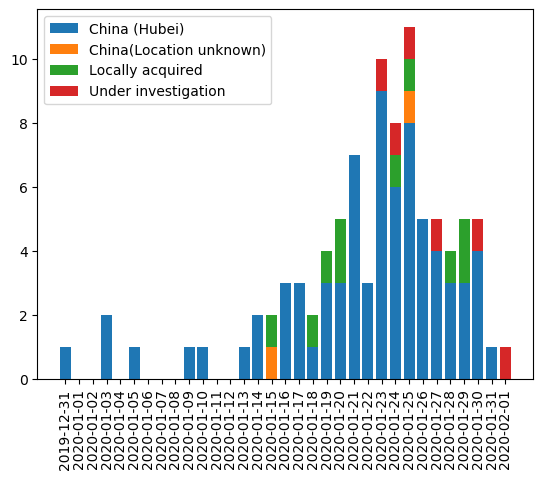

In [11]:
# Show incidence data
using DataFrames, Dates, PyPlot
# Imported and local cases outside China
# Source (accessed 4/2/2020): https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200204-sitrep-15-ncov.pdf
dates=Date("2019-12-31"):Day(1):Date("2020-2-1")
china_hubei  =[1,0,0,2,0,1,0,0,0,1,1,0,0,1,2,0,3,3,1,3,3,7,3,9,6,8,5,4,3,3,4,1,0]
china_unknown=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
localcases   =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,2,0,0,0,1,1,0,0,1,2,0,0,0]
u_inv     =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1]
casedata=DataFrame([dates,china_hubei,china_unknown,localcases,u_inv], [:date,:china_hubei,:china_unknown,:loc,:underinv])
barplots=PyPlot.bar.(Ref(1:length(casedata.date)),[Vector(casedata[:,c]) for c in 2:5],0.8,[cumsum(hcat(zeros(Int,length(casedata.date)),Matrix(casedata[:,2:5])),dims=2)[:,c] for c in 1:4])
PyPlot.xticks(1:length(casedata.date),dates,rotation="vertical")
PyPlot.legend(getindex.(barplots,1),["China (Hubei)","China(Location unknown)","Locally acquired","Under investigation"]);

In [12]:
# Data preparation
const initdate=Date("2019-9-13")
const newyeardate=Date("2020-1-1")
# Possible (earliest bound of) the estimted start of the outbreak
# Source: http://virological.org/t/preliminary-phylogenetic-analysis-of-11-ncov2019-genomes-2020-01-19/329
const timelines=initdate:Day(1):Date("2020-2-3")
const tlen=length(timelines)
imported=zeros(Int,tlen)
loc=zeros(Int,tlen)
datesid=findall(x->x in dates,timelines)
imported[datesid].=casedata.china_hubei.+casedata.china_unknown
loc[datesid].=casedata.loc
observed=(imported=imported,loc=loc);

## Setups

In [5]:
# Packages
using Mamba, Distributions
# Distributions
NBmu(mu,k)=NegativeBinomial(k,mu/(mu+k))
Gmusd(mu,sd)=Gamma(mu^2/sd^2, sd^2/mu)
module DSI
using Distributions
struct DiscreteSerialInterval{T<:NamedTuple,F<:AbstractFloat, D<:Distribution}
    params::T; dist::D; distvec::Vector{F}
end
end
function DSIconstruct(distconstructor,params,tlen)
    dist=distconstructor(params...)
    distvec=cdf.(dist,0:tlen) |> diff
    DSI.DiscreteSerialInterval(params,dist,distvec)
end
SIparams=(μ=7.0,σ=3.0)
SIdist=Gmusd(SIparams...)
serialint=DSIconstruct(Gamma,NamedTuple{(:α,:θ)}(params(SIdist)),tlen)

# utils
function sysresample(weights)
    size=length(weights)
    weights=weights/sum(weights) # normalise
    cumweights=cumsum(weights)
    randomiser=floor.(Int,cumweights.*size.+rand())
    freqs=randomiser.-[0; randomiser[1:end-1]]
    return(reduce(vcat,fill.(1:size,freqs)))
end

sysresample (generic function with 1 method)

## Simulation functions

In [264]:
using Distributions, StatsFuns, StatsBase, SpecialFunctions
function smcinfcases!(infness::NamedTuple{(:imported,:loc),T} where T,cases::NamedTuple{(:imported,:loc),T} where T,hazard::NamedTuple{(:imported,:loc),T} where T,nbparm,gtimevec,observed,detectprob)
    nsample=size(infness.imported,2)
    lweights=zeros(nsample)
    llkh=0.0
    α,p=nbparm
    θ=(1-p)/p
    for t in 1:length(observed.loc)
        # draw cases
        @views cases.imported[t,2:end].=observed.imported[t].+rand.(Poisson.((1-detectprob[t]).*hazard.imported[t]))
        @views cases.loc[t,2:end].=observed.loc[t].+rand.(Poisson.((1-detectprob[t]).*hazard.loc[t,2:end]))
        for tag in keys(cases)
            #draw gamma: total offsprings
            nonzerocase=cases[tag][t,2:end].!=0 # to avoid Gamma(0,θ)
            if sum(nonzerocase)!=0 @views infness[tag][t,2:end][nonzerocase].=rand.(Gamma.(α.*cases[tag][t,2:end][nonzerocase],θ)) end
            #distribute infness on timeline
            hazard.loc[t+1:end,2:end] .+= (@view infness[tag][t:t,2:end]).*gtimevec[1:length(observed.loc)-t]
            @views lweights.+=logpdf.(Poisson.(detectprob[t].*hazard[tag][t,:]),observed[tag][t])
        end
        if 2logsumexp(lweights)-logsumexp(2 .*lweights)< log(nsample)-log(2) || t==length(observed.loc)
            llkh+=logsumexp(lweights)-log(nsample)
            if all(lweights.≤-Inf) break end
            lweights.-=maximum(lweights)
            newid=sysresample(exp.(lweights))
            @views newid.=[1;newid[Not(rand(1:nsample))]]
            for tag in keys(cases)
                @views infness[tag][1:t,:].=infness[tag][1:t,newid]
                @views cases[tag][1:t,:].=cases[tag][1:t,newid]
            end
            @views hazard.loc[1:t,:].=hazard.loc[1:t,newid]
            lweights.=0.0
        end
        # resample
        
    end
    return(llkh)
end
function infcasesgibbs!(infness,cases,hazard,nsamples,branchdist,gtimedist,observed,detectprob,tlen)
    # infness
    infness_pts=(imported=zeros(tlen,nsamples), loc=zeros(tlen,nsamples))
    hazard_pts=(imported=hazard.imported,loc=zeros(tlen,nsamples))
    cases_pts=(imported=zeros(Int,tlen,nsamples),loc=zeros(Int,tlen,nsamples))
    # Pass the reserved particle for conditional particle filter
    for tag in keys(infness)
        infness_pts[tag][:,1].=infness[tag]
        cases_pts[tag][:,1].=cases[tag]
    end
    hazard_pts.loc[:,1].=hazard.loc
    
    gtimevec=diff(cdf.(gtimedist,0:tlen))
    counts=0
    ll=0.0
    while true
        infness_pts.imported.=0.0
        infness_pts.loc.=0.0
        hazard_pts.loc.=0.0
        ll=smcinfcases!(infness_pts,cases_pts,hazard_pts,params(branchdist),gtimevec,observed,detectprob)
        counts+=1
        if ll>-Inf break end
        if counts>100 error("infness could not be sampled in 100 SMC iterations") end
    end

    # sample one particle
    sampleid=sample(1:nsample)
    if isnan(sampleid) sanpleid=1 end
    @views infness.imported.=infness_pts.imported[:,sampleid]
    @views infness.loc.=infness_pts.loc[:,sampleid]
    @views cases.imported.=cases_pts.imported[:,sampleid]
    @views cases.loc.=cases_pts.loc[:,sampleid]
    @views hazard.loc.=hazard_pts.loc[:,sampleid]
    ll
end

function llnbdist(nbparm,infness,cases)
    α,p=nbparm
    θ=(1-p)/p
    ll=0.0
    tlen=length(infness.imported)
    for tag in keys(infness)
        for t in 1:tlen if cases[tag][t]==0 && infness[tag][t]>0.0 ll=-Inf; break end end
        ll+=sum((logpdf(Gamma(α*cases[tag][t],θ),infness[tag][t]) for t in 1:tlen if cases[tag][t]>0))
    end
    ll
end
function lldetectprob(detectprob,cases,observed)
    ll=0.0
    tlen=length(infness.imported)
    for tag in keys(infness)
        ll+=sum((logpdf(Binomial(Int(cases[tag][t]),detectprob[t]),observed[tag][t]) for t in 1:tlen))
    end
    ll
end
function llimporthazard(h0r,cases)
    h0,r=h0r
    ll=0.0
    tlen=length(cases.imported)
    ll+=sum((logpdf(Poisson(h0*exp(r*(t-Dates.value(newyeardate-initdate)-1))),cases.imported[t]) for t in 1:tlen))
    ll
end

llimporthazard (generic function with 1 method)

In [271]:
# test simulation run
nb=NBmu(2,3)
gt=Gmusd(7,1)
R0=2
k=0.5
h0=0.02
r=0.01
qt=fill(0.1,tlen)

cases=(imported=observed.imported.*2,loc=observed.loc.*2)
importhazard=[h0*exp(r*t) for t in 1:tlen]
lochazard=ones(tlen)
hazard=(imported=importhazard,loc=lochazard)
infness=(imported=observed.imported.+0.0,loc=observed.loc.+0.0)
@time lls=infcasesgibbs!(infness,cases,hazard,2000,nb,gt,observed,qt,tlen)
#@time lls=infnessgibbs!(infness,hazard.loc,500,nb,gt,tlen,cases);
#@time casescondsampler!(cases,infness,hazard,params(nb),observed,q);
@time llnbdist(params(nb),infness,cases)
@time lldetectprob(qt,cases,observed)
@time llimporthazard((h0,r),cases)
using RCall;@rimport base as R
@show R.table(lls)
mean(lls)

  1.565433 seconds (2.00 M allocations: 1.065 GiB, 25.33% gc time)
  0.000026 seconds (24 allocations: 656 bytes)
  0.000047 seconds (26 allocations: 672 bytes)
  0.000021 seconds (8 allocations: 272 bytes)
R.table(lls) = RObject{IntSxp}

-690.77257797505 
               1 



-690.7725779750502

## MCMC sampling

In [ ]:
# unknown variables: λ, i, j, R₀, k, q
parms=Dict{Symbol,Any}(
    :h₀=>0.1,
    :r=>0.1,
    :R₀=>1.0,
    :k=>0.5,
    :nlogq=>ones(Float64,tlen)
)
priors=Dict{Symbol,Any}()
for parname in keys(parms)
    priors[parname]=Stochastic(()->Uniform(0,5))
end
priors[:nlogq]=Stochastic(1,()->Uniform(0,5))

inputs=Dict{Symbol,Any}(
    :SI=>serialint,
    :observed=>observed,
    :infness=>infness,
    :cases=>cases,
    :zerotrick=>0.0,
    :invtemp=>1.0
)

inits=merge(parms,inputs)
inits=[inits]

model=Model(
    j=Logical(1,(cases)-> cases.imported),
    i=Logical(1,(cases)-> cases.loc),
    ll_smc=Logical(()->0.0,false),
    
    ll_nb=Logical(
        (R₀,k,infness,cases)->begin ll=llnbdist((R₀,k),infness,cases);print("");ll end
        , false
    ),
    ll_q=Logical(
        (nlogq,i,j,observed)->begin
            qt=exp.(.-nlogq)
            return(lldetectprob(qt,(imported=j,loc=i),observed))
        end
        , false),
    ll_h=Logical(
        (h₀,r,j)->begin llimporthazard((h₀,r),(imported=j,)) end
        , false),
    lltotal=Logical((ll_nb,ll_q,ll_h,ll_smc,invtemp)->sum((ll_nb,ll_q,ll_h,ll_smc))*invtemp
        , false),
    zerotrick=Stochastic((lltotal)->Poisson(-lltotal),false);
    priors...
)

infcasessample=Sampler(
    [:i,:j],
    (R₀,k,h₀,r,nlogq,i,j,cases,infness,observed)->begin
        hazard=(imported=h₀*exp.(r.*(Dates.value.(timelines.-newyeardate))),loc=zeros(tlen))
        nb=NBmu(R₀,k)
        cases=(imported=j,loc=i)
        infcasesgibbs!(infness,cases,hazard,smcsize,nb,serialint.dist,observed,qt,tlen)
        i,j=cases
        [i,j]
        print(".")
    end
)

compositesampler=Sampler(
    [:i,:j,:R₀,:k,:h₀,:r,:nlogq],
    (R₀,k,h₀,r,nlogq,i,j,cases,infness,observed,ll_nb,ll_q,ll_h)->begin
        # Gibbs sample with SMC
        hazard=(imported=h₀*exp.(r.*(Dates.value.(timelines.-newyeardate))),loc=zeros(tlen))
        nb=NBmu(R₀,k)
        cases=(imported=j,loc=i)
        infcasesgibbs!(infness,cases,hazard,smcsize,nb,serialint.dist,observed,qt,tlen)
        i,j=cases
        [i,j]
        print(".")
        
        # NUTS for the rest of the params
        
    end
)

setsamplers!(model,[NUTS(collect(keys(parms))),infcasessample])


In [ ]:
const smcsize=2000
chain = mcmc(model, inputs, inits, 10, burnin=2, thin=2, chains=1)

In [ ]:
module MCMC
struct MCMCStates
    
end
end
mcmc


In [ ]:
# Other functions currently not in use
function importandbranch!(cases::NamedTuple{(:imported,:loc,:infness,:hazard),NTuple{4,Vector{R}}} where R<:Real,importhazard,nbparm,gtimevec,atleastone=false)
    for t in 1:length(cases.loc)
        if sum(vec[t] for vec in cases)+importhazard[t] == 0 continue end
        
        # draw cases
        cases.imported[t]+=rand(Poisson(importhazard[t]))
        cases.loc[t]+=rand(Poisson(cases.hazard[t]))
        currinfs=cases.imported[t]+cases.loc[t]
        
        # draw gamma: total offsprings
        if currinfs!=0
            α,p=nbparm
            θ=(1-p)/p
            cases.infness[t]=rand(Gamma(α*currinfs,θ))
            #distribute infness on timeline
            cases.hazard[t+1:end].+=cases.infness[t].*gtimevec[1:length(cases.loc)-t]
            else cases.infness[t]=0.0
        end
        
        # if conditioned that infections ≧ 1
        if atleastone
            plusoneat=t+ceil(Int,sample(1:length(gtimevec),Weights(gtimevec)))
            if plusoneat<=length(cases.loc) cases.loc[plusoneat]+=1 end
            atleastone=false
        end
    end
end
# clusters generator
function importcluster(nsample,branchdist,gtimedist,tlen,importhazard)
    labels=(:imported,:loc,:infness,:hazard)
    samples=[NamedTuple{labels}(collect((zeros(Float64,tlen) for j in 1:4))) for i in 1:nsample]
    gtimevec=diff(cdf.(gtimedist,0:tlen))
    importandbranch!.(samples,Ref(importhazard),Ref(params(branchdist)),Ref(gtimevec))
    return(samples)
end

module ApproxSampler
using Distributions, SpecialFunctions
struct Vars_t{F<:AbstractFloat,T,I<:Integer}
    infness::F
    hazard::F
    nbparm::T
    observed::I
    detectprob::F
end
function poisgammacond(vars::Vars_t,x::I where I<:Integer)
    if infness==0.0
        return(pdf(Poisson(vars.hazard),x)) #!!incomplete
    end
    if vars.observed==0 && x==0 return(exp(-vars.hazard)) end #!!incomplete
    α,p=vars.nbparm
    θ=(1-p)/p
    poismean=(1-vars.detectprob)*vars.hazard*(vars.infness/θ)^α
    pdf(Poisson(poismean),x)/gamma(α*(vars.observed+x))
end
function discreteapproxsampler(densityfunc,paramobj,upper,tol=1e-4)
    u=rand()
    sumcdf=0.0
    Δcdf=0.0
    xmax=0
    while xmax≤upper ||  Δcdf/sumcdf>tol
        Δcdf=densityfunc(paramobj,xmax)
        sumcdf+=Δcdf
        xmax+=1
    end
    funccdf=0.0
    xsample=0
    for x in 0:xmax-1
        xsample=x
        funccdf+=densityfunc(paramobj,x)/sumcdf
        if funccdf≥u break end
    end
    return(xsample)
end
end
function casescondsampler!(cases,infness,hazard,nbparm,observed,detectprob)
    for tag in (:imported,:loc)
        cases[tag].=observed[tag].+
            ApproxSampler.discreteapproxsampler.(
                ApproxSampler.poisgammacond,
                ApproxSampler.Vars_t.(infness[tag],hazard[tag],Ref(nbparm),observed[tag],detectprob),
                hazard[tag])
    end
end
function casesgibbs()
    
end

function smcinfness!(infness::NamedTuple{(:imported,:loc),T} where T,lochazard::Matrix{<:AbstractFloat},cases::NamedTuple{(:imported,:loc),T} where T,nbparm,gtimevec)
    nsample=size(infness.imported,2)
    lweights=zeros(nsample)
    lkh=zeros(nsample)
    α,p=nbparm
    θ=(1-p)/p
    for t in 1:length(cases.loc)
        if cases.imported[t] != 0
            # draw gamma: total offsprings
            infness.imported[t,:].=rand(Gamma(α*cases.imported[t],θ),nsample)
            #distribute infness on timeline
            @views lochazard[t+1:end,:].+=infness.imported[t:t,:].*gtimevec[1:length(cases.loc)-t]
        end
        if cases.loc[t] != 0
            # draw gamma: total offsprings
            infness.loc[t,:].=rand(Gamma(α*cases.loc[t],θ),nsample)
            #distribute infness on timeline
            @views lochazard[t+1:end,:].+=infness.loc[t:t,:].*gtimevec[1:length(cases.loc)-t]
        end
        
        # filter particle
        @views lweights.+=logpdf.(Poisson.(lochazard[t,:]),cases.loc[t])
        #if(2logsumexp(weights)-logsumexp(2 .*weights)< log(nsample)-log(2))
            # resample

            lkh.+=lweights
        if all(lweights.≤-Inf) break end
            lweights.-=maximum(lweights)
            newid=sysresample(exp.(lweights))
            @views infness.imported[1:t,:].=infness.imported[1:t,newid]
            @views infness.loc[1:t,:].=infness.loc[1:t,newid]
            @views lochazard[1:t,:].=lochazard[1:t,newid]
            @views lkh.=lkh[newid]
            lweights.=0.0
        #end
    end
    return(lkh)
end

function infnessgibbs!(infness,lochazard,nsamples,branchdist,gtimedist,tlen,cases)
    # infness
    infness_pts=(imported=zeros(tlen,nsamples), loc=zeros(tlen,nsamples))
    lochazard_pts=zeros(tlen,nsamples)
    gtimevec=diff(cdf.(gtimedist,0:tlen))
    counts=0
    lls=zeros(nsamples)
    while true
        infness_pts.imported.=0.0
        infness_pts.loc.=0.0
        lochazard_pts.=0.0
        lls.=smcinfness!(infness_pts,lochazard_pts,cases,params(branchdist),gtimevec)
        counts+=1
        if sum(lls)>-Inf break end
        if counts>100 error("infness could not be sampled in 100 SMC iterations") end
    end
    # sample from lls
    sampleid=sample(Weights(exp.(lls.-maximum(lls))))
    if isnan(sampleid) sanpleid=1 end
    @views infness.imported.=infness_pts.imported[:,sampleid]
    @views infness.loc.=infness_pts.loc[:,sampleid]
    @views lochazard.=lochazard_pts[:,sampleid]
    lls
end

